# Hodgkin Huxley Model of Action Potential Generation

In this notebook we want to explore the Hodgkin-Huxley model equations. I.e., we want to model an action potential in the membrane potential $u$, whose dynamics is governed by
$$
 C_m \frac{\mathrm{d}u}{\mathrm{d}t}=-\bar g_{Na}m^3h(u-E_{Na})-\bar g_{K}n^4(u-E_{K})-\bar g_{L}(u-E_{L}) + I(t),
$$
where $I(t)$ is an externally-imposed input current, and $m$,$h$, and $n$ control the opening and closing of ion channels in the cell membrane. They are assumed to obey linear dynamics according to
$$
 \frac{\mathrm{d}n}{\mathrm{d}t}-\frac{1}{\tau_n(u)}(n-n_0(u)),\\
 \frac{\mathrm{d}m}{\mathrm{d}t}-\frac{1}{\tau_m(u)}(m-m_0(u)),\\
 \frac{\mathrm{d}h}{\mathrm{d}t}-\frac{1}{\tau_h(u)}(h-h_0(u)).
$$
The dependence of the levels $n_0$, $m_0$, $h_0$ and the time constants on the potential $u$, as well as the remaining constants $\bar g_{Na}$, $\bar g_{K}$, $\bar g_{L}$, $E_{Na}$, $E_{K}$, $E_{L}$ can be fitted to experimental data.

### Imports

In [38]:
import numpy as np 
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl

import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)

# Mpl setup
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

### Biological Variables

In [127]:
# Reversal potentials
E_Na, E_K, E_L, E_rest = (55,-77,-65, -63) #mV

# Conductances
g_Na, g_K, g_L = (40, 35, 0.3) #S/cm^2

# Membrane capacitance
C_m = 1e-3 #mF/cm^2

# n
alpha_n = lambda u: 0.02*(u-25)/(1-np.exp(-(u-25)/9)) #ms^(-1)
beta_n = lambda u: -0.002*(u-25)/(1-np.exp((u-25)/9)) #ms^(-1)
n_0 = lambda u: alpha_n(u)/(alpha_n(u) + beta_n(u))
tau_n = lambda u: 1/(alpha_n(u) + beta_n(u))

# m
alpha_m = lambda u: 0.182*(u+35)/(1-np.exp(-(u+35)/9)) #ms^(-1)
beta_m = lambda u: -0.124*(u+35)/(1-np.exp((u+35)/9)) #ms^(-1)
m_0 = lambda u: alpha_m(u)/(alpha_m(u) + beta_m(u))
tau_m = lambda u: 1/(alpha_m(u) + beta_m(u))

# h
alpha_h = lambda u: 0.25*np.exp(-(u+90)/12) #ms^(-1)
beta_h = lambda u: 0.25*np.exp((u+62)/6-(u+90)/12) #ms^(-1)
h_0 = lambda u: alpha_h(u)/(alpha_h(u) + beta_h(u))
tau_h = lambda u: 1/(alpha_h(u) + beta_h(u))

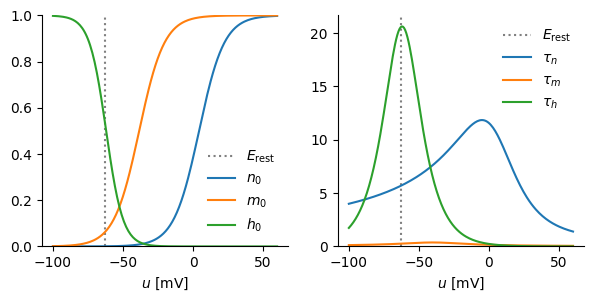

In [128]:
fig, axs = plt.subplots(1,2,figsize=(7,3))

u_array = np.linspace(-100,60,200)

axs[0].axvline(E_rest, ls=':', c='grey', label=r'$E_\text{rest}$')
axs[0].plot(u_array, n_0(u_array), label=r'$n_0$')
axs[0].plot(u_array, m_0(u_array), label=r'$m_0$')
axs[0].plot(u_array, h_0(u_array), label=r'$h_0$')
axs[0].set_xlabel(r'$u$ [mV]')
axs[0].set_ylim(0,1)
axs[0].legend(frameon=False)

axs[1].axvline(E_rest, ls=':', c='grey', label=r'$E_\text{rest}$')
axs[1].plot(u_array, tau_n(u_array), label=r'$\tau_n$')
axs[1].plot(u_array, tau_m(u_array), label=r'$\tau_m$')
axs[1].plot(u_array, tau_h(u_array), label=r'$\tau_h$')
axs[1].set_xlabel(r'$u$ [mV]')
axs[1].set_ylim(0)
axs[1].legend(frameon=False)

## Differential Equations

In [129]:
def HodgkinHuxley(t, y, I):
    u, n, m, h = y

    du = (-g_Na*m**3*h*(u-E_Na)-g_K*n**4*(u-E_K)-g_L*(u-E_L) + I(t))/C_m
    dn = -(n-n_0(u))/tau_n(u)
    dm = -(m-m_0(u))/tau_m(u)
    dh = -(h-h_0(u))/tau_h(u)

    return (du,dn,dm,dh)

In [187]:
I0 = 1
I = lambda t: I0*np.heaviside(t-1, 1.0)*np.heaviside(1.3-t, 1.0) # I0 in the interval from t=1 to t=2

In [211]:
T= 10
plot_n = 200
y0 = (E_rest, n_0(E_rest), m_0(E_rest), h_0(E_rest))
out = sp.integrate.solve_ivp(HodgkinHuxley, (0, T), y0, t_eval=np.linspace(0, T, plot_n), method='BDF', args=(I,), max_step=1e-3)

In [212]:
out

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.025e-02 ...  9.950e+00  1.000e+01]
        y: [[-6.300e+01 -6.303e+01 ... -6.467e+01 -6.467e+01]
            [ 5.667e-04  5.666e-04 ...  1.057e-02  1.048e-02]
            [ 6.138e-02  6.134e-02 ...  5.142e-02  5.143e-02]
            [ 5.416e-01  5.416e-01 ...  1.500e-01  1.511e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 20021
     njev: 5
      nlu: 1563

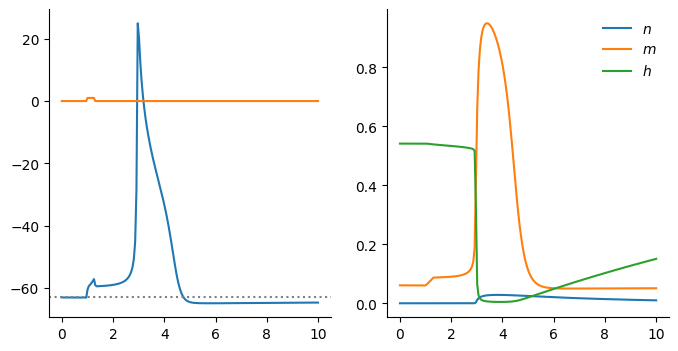

In [214]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

axs[0].plot(out.t,out.y[0])
axs[0].plot(out.t,I(out.t))
axs[0].axhline(E_rest, ls=':', c='grey')

axs[1].plot(out.t,out.y[1], label=r'$n$')
axs[1].plot(out.t,out.y[2], label=r'$m$')
axs[1].plot(out.t,out.y[3], label=r'$h$')
axs[1].legend(frameon=False)

## Paper Figure

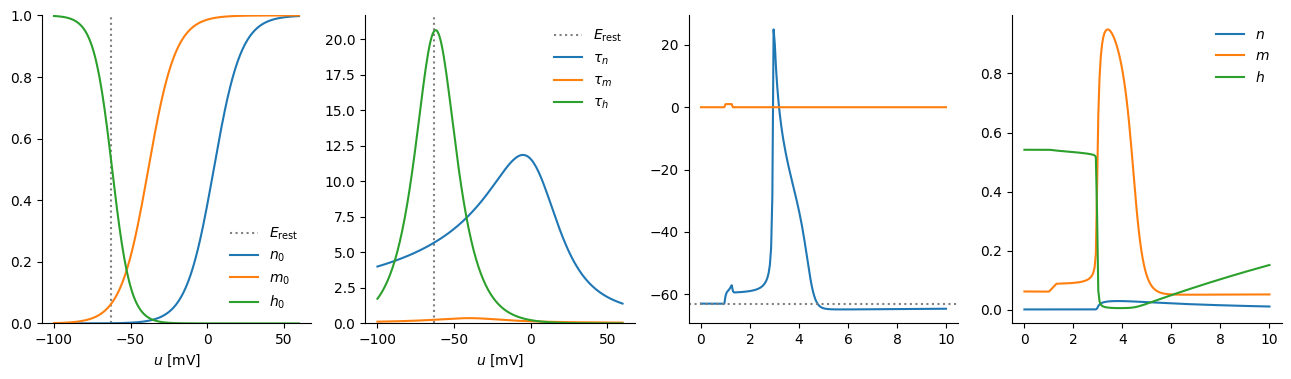

In [225]:
fig, axs = plt.subplots(1,4,figsize=(16,4))

u_array = np.linspace(-100,60,200)

axs[0].axvline(E_rest, ls=':', c='grey', label=r'$E_\text{rest}$')
axs[0].plot(u_array, n_0(u_array), label=r'$n_0$')
axs[0].plot(u_array, m_0(u_array), label=r'$m_0$')
axs[0].plot(u_array, h_0(u_array), label=r'$h_0$')
axs[0].set_xlabel(r'$u$ [mV]')
axs[0].set_ylim(0,1)
axs[0].legend(frameon=False)

axs[1].axvline(E_rest, ls=':', c='grey', label=r'$E_\text{rest}$')
axs[1].plot(u_array, tau_n(u_array), label=r'$\tau_n$')
axs[1].plot(u_array, tau_m(u_array), label=r'$\tau_m$')
axs[1].plot(u_array, tau_h(u_array), label=r'$\tau_h$')
axs[1].set_xlabel(r'$u$ [mV]')
axs[1].set_ylim(0)
axs[1].legend(frameon=False)

axs[2].plot(out.t,out.y[0])
axs[2].plot(out.t,I(out.t))
axs[2].axhline(E_rest, ls=':', c='grey')

axs[3].plot(out.t,out.y[1], label=r'$n$')
axs[3].plot(out.t,out.y[2], label=r'$m$')
axs[3].plot(out.t,out.y[3], label=r'$h$')
axs[3].legend(frameon=False)

Save figure

In [226]:
fig.tight_layout()
fig.savefig('/data.nst/sbauer/projects/heart-and-brain/figures/hodgkin-huxley.pdf')

In [ ]:
e